### Import Libraries


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [5]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [6]:
# Import some other useful libraries or functions
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import keras_cv.layers as kcvl
from tensorflow.keras.utils import unpack_x_y_sample_weight

Using TensorFlow backend


In [7]:
data = np.load('/kaggle/input/challenge1/dataset.npz',allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

### Create train and validation sets

In [8]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label.decode()] for label in y])

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)


# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

del X_train_val, y_train_val

### Define the Model

In [9]:
# Instantiate a ConvNeXtXLarge model with pre-trained ImageNet weights for transfer learning.
# References:
#   [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545)

# Configure the model to exclude the top layer, set the input shape of our problem, specify
# the number of output classes, and use softmax activation.
convnext = tf.keras.applications.ConvNeXtXLarge(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
    #pooling='avg',
    classes=2,
    classifier_activation='softmax',
)

# Froze the model's weights (non-trainable) to preserve pre-trained knowledge.
convnext.trainable = False

1393257616/1393257616 [==============================] - 6s 0us/step


In [10]:
# Define an image augmentation pipeline using TensorFlow's Keras Sequential API.
# The pipeline includes
# - RandAugment technique [RandAugment: Practical automated data augmentation with a 
#   reduced search space](https://arxiv.org/abs/1909.13719),
# - RandomFlip (horizontal or vertical flips),
# - RandomZoom,
# - RandomRotation.

img_augmentation = tf.keras.Sequential(
    [
    kcvl.RandAugment(
    # parameters set as in the paper
    value_range = (0,1),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.15,
    rate=0.9090909090909091,
    geometric=True,
    seed=seed),
    tfkl.RandomFlip(),
    tfkl.RandomRotation(factor= 0.5),
    ],
    name="img_augmentation",)

In [11]:
class CustomModel(tfk.Model):
    def train_step(self, data):
        """
            We override the train_step() method in the Model class to selectively
            activate the RandAugment preprocessing layer only during training,
            rather than during validation or testing. This ensures that the
            RandAugment layer is invoked externally to the Model, but consistently
            applies its random transformations each time an image is fed into the
            model during training. By customizing the train_step() behavior, we
            integrate the RandAugment functionality seamlessly into the training
            process.

            Code readapted from source code:
            https://github.com/keras-team/keras/blob/v2.14.0/keras/engine/training.py#L1189-L1226
        """
        x, y, sample_weight = tf.keras.utils.unpack_x_y_sample_weight(data)

        # Perform augmentation on the input data for training
        x = img_augmentation(x, training= True)

        # Run forward pass.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(x, y, y_pred, sample_weight)
        self._validate_target_and_loss(y, loss)
        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        return self.compute_metrics(x, y, y_pred, sample_weight)

    def compile(self, *args, **kwargs):
        super(CustomModel, self).compile(*args, **kwargs, metrics=['accuracy'])

In [12]:
def build_convnextaug(input_shape=(96, 96, 3)):
    """
        Build a ConvNeXtLarge-based CNN with image augmentation, and a custom
        classifier for binary classification of healthy and unhealthy leaves.
    """
    tf.random.set_seed(seed)
    inputs = tfk.Input(shape=input_shape)

    # Cast input
    augmented_255 = tf.cast(inputs* 255, tf.uint8)

    x1 = convnext(augmented_255)
    x2 = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    norm = tfkl.BatchNormalization(name="batch_normalization")(x2)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    intermediate1 = tfkl.Dense(1024, activation=tf.keras.activations.swish)(norm)

    outputs = tfkl.Dense(2, activation='softmax')(intermediate1)

    # Create a Model connecting input and output
    model = CustomModel(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    optimizer = tf.keras.optimizers.AdamW()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer)

    # Return the model
    return model

### Plot of History and LR Scheduler

In [13]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLearning(Callback):
    """
    Callback for plotting the learning curves of a model during training.

    This callback records and visualizes training and validation metrics (e.g.,
    loss, accuracy) after each epoch to provide insights into the model's
    performance.

    Methods:
    - on_train_begin: Initializes a dictionary to store training metrics.
    - on_epoch_end: Collects and stores metrics after each epoch and plots the
    learning curves.
    """
    def on_train_begin(self, logs={}):
        # Initializes a dictionary to store training metrics
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []


    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        # Set up subplots
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        # Convert axs to a numpy array for indexing
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])

        # Plot learning curves
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(curr_epoch, curr_lr, start= 60, rate= 0.008):
    """
    Learning rate scheduler function.

    This function adjusts the learning rate during training.
    It keeps the initial learning rate unchanged until the 40th epoch,
    after which it exponentially decreases the learning rate.

    Parameters:
    - curr_epoch: The current epoch index.
    - curr_lr: The current learning rate.
    - start: The epoch at which the exponential decay starts (default: 40).
    - rate: The rate controlling the decay (default: 0.008).

    Returns:
    - Updated learning rate.
    """
    if curr_epoch < start:
        return curr_lr
    else:
        return curr_lr * tf.math.exp(-rate)

## Transfer Learning

In [15]:
# Define the path pattern for saving checkpoints and extract the directory
checkpoint_path = "convnext_TL/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Configure a callback to save the best model based on validation accuracy
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

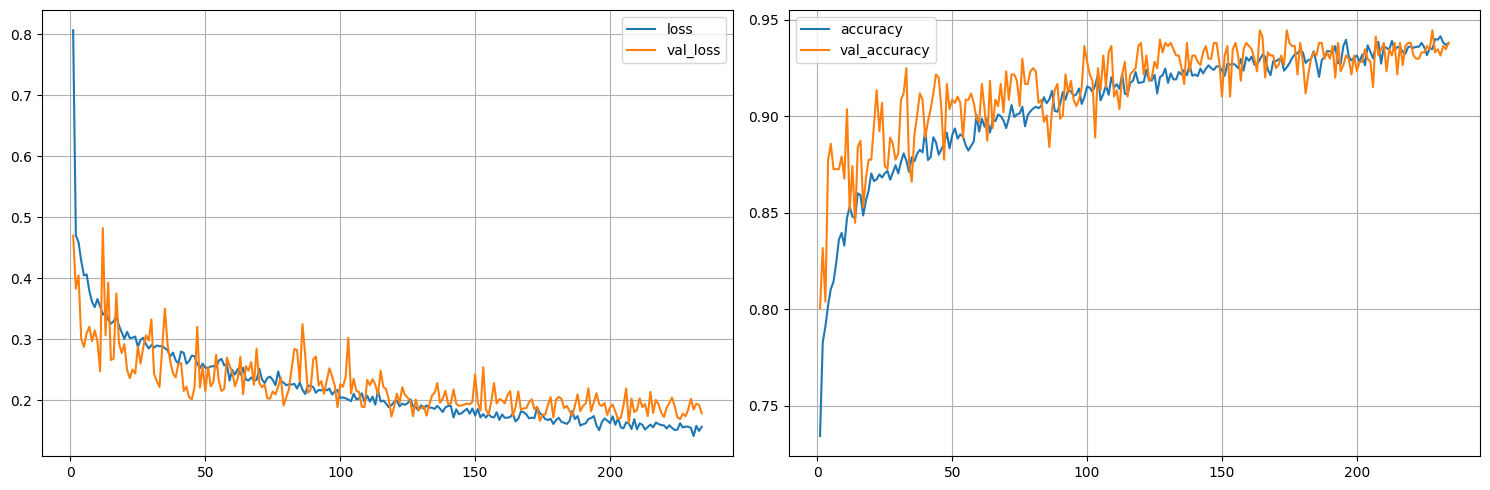

345/345 [==============================] - 83s 239ms/step - loss: 0.1565 - accuracy: 0.9379 - val_loss: 0.1786 - val_accuracy: 0.9379 - lr: 2.4858e-04


In [17]:
# Build a ConvNeXtLarge model for transfer learning
tl_model = build_convnextaug()

# Set up a learning rate scheduler and a custom plotting callback, as well as
# checkpoints
lr_schedule = LearningRateScheduler(lr_scheduler)
callbacks_list = [PlotLearning()]
callbacks = [cp_callback]

# Train the model with transfer learning
tl_history = tl_model.fit(
    x = X_train, # input training data
    y = y_train,  # target training data
    batch_size = 16,
    epochs = 700,
    validation_data = (X_val, y_val), # validation data
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy',
                                             mode='max',
                                             patience=70,
                                             restore_best_weights=True),
                 callbacks_list,
                 lr_schedule,
                 callbacks]
).history

In [19]:
model_name = 'convnext_TL_aug'

# Save the trained ConvNeXt model with transfer learning
tl_model.save(model_name)

print("Finished training of ", model_name, " model. Model saved successfully.")

Finished training of  convnext_TL_aug  model. Model saved successfully.


In [20]:
# Lists to store evaluation metrics
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

# Evaluate the last model on validation and training sets
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

# Update the lists with the evaluation metrics
val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

# Display the evaluation metrics for the last model
print("Last model evaluation:")
print("Train loss:", last_train_loss)
print("Train accuracy:", last_train_accuracy)
print("Validation loss:", last_val_loss)
print("Validation accuracy:", last_val_accuracy)

173/173 [==============================] - 52s 303ms/step - loss: 0.0529 - accuracy: 0.9804
Last model evaluation:
Train loss: 0.05285150930285454
Train accuracy: 0.9803921580314636
Validation loss: 0.17440728843212128
Validation accuracy: 0.9444444179534912


# Fine Tuning

In [21]:
# Save weights of the Transfer Learning model
tl_model.save_weights('convnext_TL_weights')

In [22]:
# Create a new instance of CustomModel for fine-tuning
ft_model = build_convnextaug()

# Load the weights for the model
ft_model.load_weights('convnext_TL_weights')

In [23]:
# Set all layers as trainable
ft_model.trainable = True

if all(layer.trainable for layer in ft_model.layers):
    print("Successful!")
else:
    print("Error!")

ft_model.get_layer('batch_normalization').trainable = False

Successful!


In [24]:
# Display the summary of the Transfer Learning model
ft_model.summary()

# Display the layers and their trainable status within the 'convnext_large' submodule
print("Layers within 'convnext_large' submodule:")
for i, layer in enumerate(ft_model.get_layer('convnext_xlarge').layers):
    print(i, layer.name, layer.trainable)

print("\n")

# Display all layers in the entire model and their trainable status
print("All layers in the model:")
for i, layer in enumerate(ft_model.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.multiply_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 96, 96, 3)         0         
                                                                 
 convnext_xlarge (Functiona  (None, 3, 3, 2048)        348147968 
 l)                                                              
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                             

In [ ]:
# Run this cell to run half of the layers.

# Freeze the first N layers (approximately the first half) of the
# 'convnext_large' submodule.
# Also the fully-connected part will train.
N = 149
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
    layer.trainable = False

# Display the layers and their updated trainable status within the submodule
print("Updated trainable status after freezing layers:")
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
    print(i, layer.name, layer.trainable)

In [ ]:
# Define the path pattern for saving checkpoints and extract the directory
checkpoint_path = "convnext_FT/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Configure a callback to save the best model based on validation accuracy
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler_ft(curr_epoch, curr_lr, start= 10, rate= 0.05):
    """
    Learning rate scheduler function for fine-tuning.

    This function adjusts the learning rate during training.
    It keeps the initial learning rate unchanged until the 40th epoch,
    after which it exponentially decreases the learning rate.

    Parameters:
    - curr_epoch: The current epoch index.
    - curr_lr: The current learning rate.
    - start: The epoch at which the exponential decay starts (default: 40).
    - rate: The rate controlling the decay (default: 0.008).

    Returns:
    - Updated learning rate.
    """
    if curr_epoch < start:
        return curr_lr
    else:
        return curr_lr * tf.math.exp(-rate)

In [26]:
# Set up a learning rate scheduler and a custom plotting callback, as well as
# checkpoints
lr_schedule = LearningRateScheduler(lr_scheduler_ft)
callbacks_list = [PlotLearning()]
callbacks = [cp_callback]

# Compile the Transfer Learning model: use a lower learning rate for fine-tuning,
# as well as increase the weight decay regularization, to prevent overfitting
ft_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate=5e-5,
                                   weight_decay= 0.01),
)

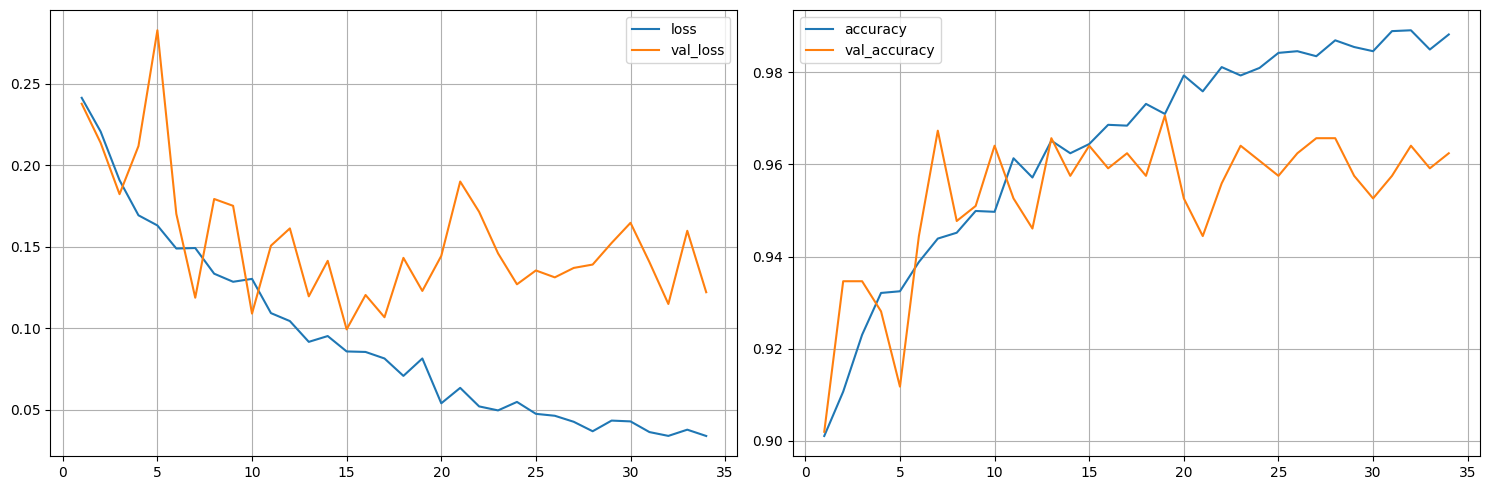

345/345 [==============================] - 234s 678ms/step - loss: 0.0338 - accuracy: 0.9882 - val_loss: 0.1220 - val_accuracy: 0.9624 - lr: 1.5060e-05


In [27]:
# Train the model with fine-tuning
print("Last part of CNN is training.")
ft_history = ft_model.fit(
    x = X_train, # input training data
    y = y_train,  # target training data
    batch_size = 16,
    epochs = 150,
    validation_data = (X_val, y_val), # validation data
    callbacks = [tfk.callbacks.EarlyStopping(monitor= 'val_accuracy',
                                             mode= 'max',
                                             patience= 15,
                                             restore_best_weights= True),
                 callbacks_list,
                 lr_schedule,
                 callbacks]
).history

In [29]:
model_name = 'convnext_FT_aug_new'

# Save the trained ConvNeXt model with transfer learning
ft_model.save(model_name)

print("Finished training of ", model_name, " model. Model saved successfully.")

Finished training of  convnext_FT_aug_new  model. Model saved successfully.


In [30]:
# Evaluate the last model on validation and training sets
last_val_loss, last_val_accuracy = ft_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = ft_model.evaluate(X_train, y_train)

# Update the lists with the evaluation metrics
val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

# Display the evaluation metrics for the last model
print("Last model evaluation:")
print("Train loss:", last_train_loss)
print("Train accuracy:", last_train_accuracy)
print("Validation loss:", last_val_loss)
print("Validation accuracy:", last_val_accuracy)

173/173 [==============================] - 53s 304ms/step - loss: 0.0092 - accuracy: 0.9973
Last model evaluation:
Train loss: 0.0091709578409791
Train accuracy: 0.9972766637802124
Validation loss: 0.12275809049606323
Validation accuracy: 0.970588207244873
